In [62]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import tqdm

import mltools.utils.cuda_tools as cuda_tools
from mltools.networks import networks

device=cuda_tools.get_freer_device()

import sys
sys.path.append('../')

import utils
import models
import importlib
importlib.reload(utils)

memory_available [65727]
best GPU: 0


<module 'utils' from '/n/home12/cfpark00/ML/ToyCompDiff/utils.py'>

In [4]:
os.chdir('/n/home12/cfpark00/ML/ToyCompDiff')

In [22]:
net=networks.CUNet(shape=(3,32,32),out_channels=64,chs=[32,32,32],norm_groups=4)
classifier=models.Classifier(net=net,n_classes=[2,2])#,n_classes=[2,2,2])
classifier=classifier.to(device)
#classifier.load_state_dict(torch.load("./data/images_1/circle_noxy_inis=0.3/classifier.pth"))
#classifier.load_state_dict(torch.load("./data/images_1/2x2x2/classifier.pth"))
classifier.load_state_dict(torch.load("./data/images_1/2x2/classifier_combined.pth"))
classifier=classifier.eval()

In [54]:
#os.chdir('/n/home12/cfpark00/ML/vectorCG')
plot_datas=[]
acc_sigma=5
det_model=False#True

for fol in glob.glob("./data/images_1/2x2/mcfs_fast/seed=*"):
    config_file=glob.glob(os.path.join(fol,"*.yaml"))[0]
    config=utils.load_config(config_file)
    logs_file=os.path.join(fol,"logs.pth")
    logs=torch.load(logs_file)

    x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config,forgen=True)
    n_classes=config["data_params"]["n_classes"]
    #losses
    loss_keys=["elbo","diffusion_loss","latent_loss","reconstruction_loss"]
    if det_model:
        losses_perclass={l:[] for l in range(n_classes)}
    else:
        loss_keys=["elbo","diffusion_loss","latent_loss","reconstruction_loss"]
        losses_perclass={l:dict(zip(loss_keys,[[] for _ in range(len(loss_keys))])) for l in range(n_classes)}
    ckpts=[]
    classprobs_pred_tr=[]
    classprobs_pred_te=[]
    gens_tr=[]
    gens_te=[]
    model=utils.get_model(config)
    #def get_step(path):
    #    return int(path.split("step=")[-1].split(".")[0])
    #ckpt_paths=glob.glob(os.path.join(fol,"ckpts","*.pth"))
    #ckpt_paths=sorted(ckpt_paths,key=get_step)
    #ckpt_paths=["/n/home12/cfpark00/ML/ToyCompDiff/data/images_1/circle_noxy_inis=0.3/seed=0/ckpts/ckpt_step=122440.pth"]
    ckpt_paths=logs["ckpt_paths"]
    
    for ckpt_path in tqdm.tqdm(ckpt_paths):
        ckpt=torch.load(ckpt_path)
        if not det_model:
            for key in list(ckpt.keys()):
                if key[:4]=="net.":
                    del ckpt[key]
        ckpts.append(ckpt)
        model.load_state_dict(ckpt)
        model=model.to(device)
        x_tr_torch=torch.tensor(x_tr).to(device=device,dtype=torch.float32)
        y_tr_torch=torch.tensor(y_tr).to(device=device,dtype=torch.float32)
        x_te_torch=torch.tensor(x_te).to(device=device,dtype=torch.float32)
        y_te_torch=torch.tensor(y_te).to(device=device,dtype=torch.float32)
        ##loss
        with torch.no_grad():
            if det_model:
                loss_tr=model.get_loss(x=x_tr_torch,c=y_tr_torch,reduction="none").mean(-1)
                loss_te=model.get_loss(x=x_te_torch,c=y_te_torch,reduction="none").mean(-1)
            else:
                loss_tr=model.get_loss(x=x_tr_torch,c=y_tr_torch,reduction="none")[1]#decomposed loss
                loss_te=model.get_loss(x=x_te_torch,c=y_te_torch,reduction="none")[1]#decomposed loss
        if det_model:
            for l in range(n_classes):
                in_tr=np.any(l_tr==l)
                if in_tr:
                    losses_perclass[l].append(loss_tr[l_tr==l].cpu().numpy())
                else:
                    losses_perclass[l].append(loss_te[l_te==l].cpu().numpy())
        else:
            for loss_key in loss_keys:
                for l in range(n_classes):
                    in_tr=np.any(l_tr==l)
                    if in_tr:
                        losses_perclass[l][loss_key].append(loss_tr[loss_key][l_tr==l].cpu().numpy())
                    else:
                        losses_perclass[l][loss_key].append(loss_te[loss_key][l_te==l].cpu().numpy())
        with torch.no_grad():
            gen_tr=model.generate(y_tr_torch)
            classprob_pred_tr=classifier.classify(gen_tr,return_probs=True)
            classprob_pred_tr=[el.detach().cpu().numpy() for el in classprob_pred_tr]

            gen_te=model.generate(y_te_torch)
            classprob_pred_te=classifier.classify(gen_te,return_probs=True)
            classprob_pred_te=[el.detach().cpu().numpy() for el in classprob_pred_te]

            gen_tr=gen_tr.detach().cpu().numpy()
            gen_te=gen_te.detach().cpu().numpy()
        classprobs_pred_tr.append(classprob_pred_tr)
        classprobs_pred_te.append(classprob_pred_te)
        gens_tr.append(gen_tr)
        gens_te.append(gen_te)
    if det_model:
        for l in range(n_classes):
            losses_perclass[l]=np.stack(losses_perclass[l],axis=0)
    else:
        for l in range(n_classes):
            for loss_key in loss_keys:
                losses_perclass[l][loss_key]=np.stack(losses_perclass[l][loss_key],axis=0)

    gens_tr=np.stack(gens_tr,axis=0)
    gens_te=np.stack(gens_te,axis=0)

    rightprobss_tr=[]
    rightprobss_te=[]
    rights_tr=[]
    rights_te=[]
    indarr_tr=np.arange(len(l_tr))
    right_classes_tr=classifier.unravel_index(l_tr)
    indarr_te=np.arange(len(l_te))
    right_classes_te=classifier.unravel_index(l_te)
    for i_step in range(len(classprobs_pred_tr)):
        rightprobs_tr=[]
        rightprobs_te=[]
        rights_tr_=[]
        rights_te_=[]
        for i_con in range(len(right_classes_tr)):
            rightprob_tr=classprobs_pred_tr[i_step][i_con][indarr_tr,right_classes_tr[i_con]]
            rightprobs_tr.append(rightprob_tr)
            rights_tr_.append(classprobs_pred_tr[i_step][i_con].argmax(-1)==right_classes_tr[i_con])
            rightprob_te=classprobs_pred_te[i_step][i_con][indarr_te,right_classes_te[i_con]]
            rightprobs_te.append(rightprob_te)
            rights_te_.append(classprobs_pred_te[i_step][i_con].argmax(-1)==right_classes_te[i_con])
        rightprobss_tr.append(np.stack(rightprobs_tr,axis=-1))
        rights_tr.append(np.stack(rights_tr_,axis=-1))
        rightprobss_te.append(np.stack(rightprobs_te,axis=-1))
        rights_te.append(np.stack(rights_te_,axis=-1))
    rightprobss_tr=np.stack(rightprobss_tr,axis=0)
    rights_tr=np.stack(rights_tr,axis=0)
    rightprobss_te=np.stack(rightprobss_te,axis=0)
    rights_te=np.stack(rights_te,axis=0)

    #accs_perclass={}

    plot_data={}
    plot_data["gens_tr"]=gens_tr
    plot_data["gens_te"]=gens_te
    plot_data["min_vlb"]=model.get_min_vlb() if hasattr(model,"get_min_vlb") else 0
    plot_data["save_steps"]=logs["save_steps"]
    plot_data["losses"]=logs["losses"]
    plot_data["val_losses"]=logs["val_losses"]
    plot_data["te_losses"]=logs["te_losses"]
    #plot_data["losses_perclass"]=losses_perclass
    #plot_data["accs_perclass"]=accs_perclass
    plot_data["l_tr"]=l_tr
    plot_data["rights_tr"]=rights_tr
    plot_data["l_te"]=l_te
    plot_data["rights_te"]=rights_te
    plot_data["classprobs_pred_tr"]=classprobs_pred_tr
    plot_data["classprobs_pred_te"]=classprobs_pred_te
    plot_data["rightprobss_tr"]=rightprobss_tr
    plot_data["rightprobss_te"]=rightprobss_te
    plot_data["ckpts"]=ckpts
    plot_datas.append(plot_data)

100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


In [55]:
tri=[0,1,2,4]

In [56]:
#plt.plot(plot_data["save_steps"],rights_tr[:,:,1].mean(-1))
#plt.plot(plot_data["save_steps"],rights_te[:,:,1].mean(-1))
rightss_tr=[]
rightss_te=[]
for i in range(len(plot_datas)):
    plot_data=plot_datas[i]
    save_steps=plot_data["save_steps"]
    rights_tr=plot_data["rights_tr"]
    rights_te=plot_data["rights_te"]
    rightss_tr.append(rights_tr)
    rightss_te.append(rights_te)
rightss_tr=np.stack(rightss_tr,axis=0)
rightss_te=np.stack(rightss_te,axis=0)
rightss_tr.shape,rightss_te.shape

((3, 20, 96, 2), (3, 20, 32, 2))

In [57]:
gen_te.shape

(32, 3, 32, 32)

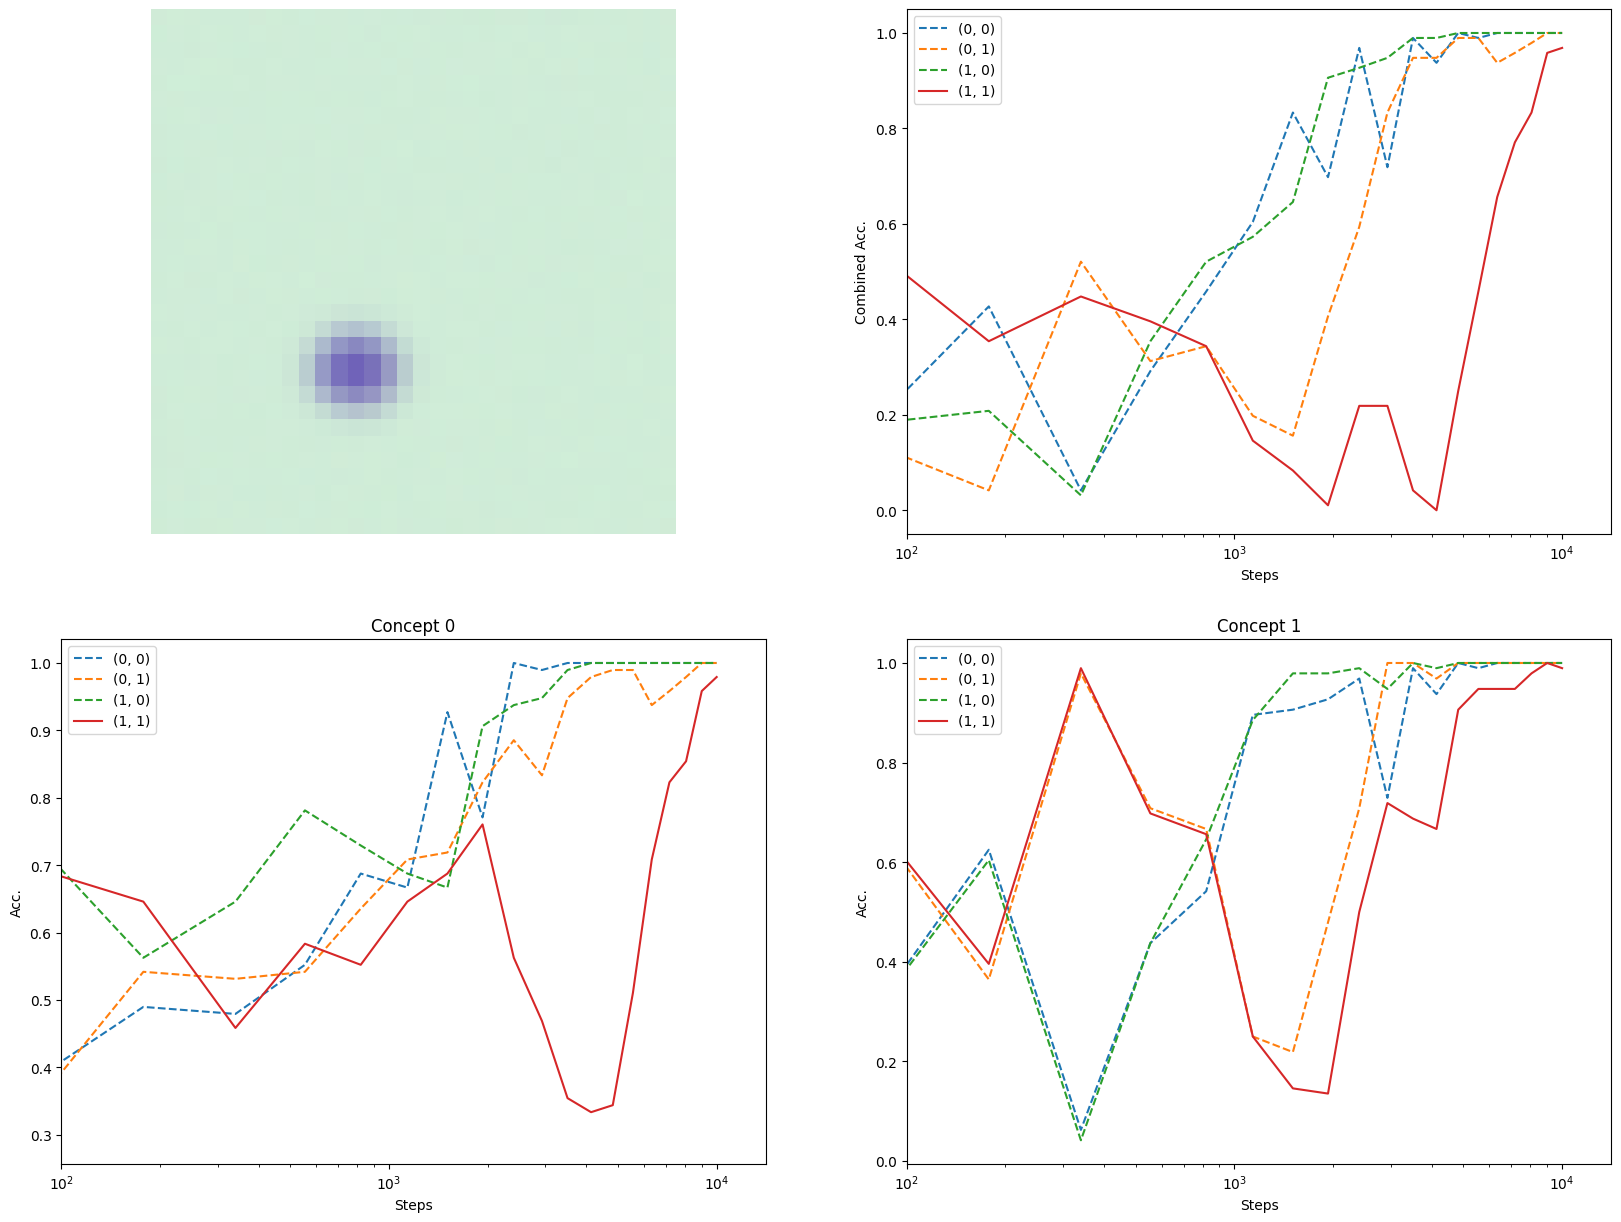

In [58]:
fig=plt.figure(figsize=(20,15))
l=3
plt.subplot(2,2,1)
plt.imshow(gen_te[l_te==l][0].transpose(1,2,0),origin="lower")
plt.axis("off")


plt.subplot(2,2,2)
for l in range(n_classes):
    if l in tri:
        plt.plot(save_steps,rightss_tr[:,:,l_tr==l].prod(-1).mean(-1).mean(0),ls="--",label=f"{classifier.unravel_index(l)}")
    else:
        plt.plot(save_steps,rightss_te[:,:,l_te==l].prod(-1).mean(-1).mean(0),label=f"{classifier.unravel_index(l)}")
plt.xscale("log")
plt.xlim(left=100)
plt.legend()
plt.ylabel("Combined Acc.")
plt.xlabel("Steps")

n_concepts=len(classifier.n_classes)
for i_concept in range(n_concepts):
    plt.subplot(2,n_concepts,n_concepts+i_concept+1)
    for l in range(n_classes):
        if l in tri:
            plt.plot(save_steps,rightss_tr[:,:,l_tr==l][...,i_concept].mean(-1).mean(0),ls="--",label=f"{classifier.unravel_index(l)}")
        else:
            plt.plot(save_steps,rightss_te[:,:,l_te==l][...,i_concept].mean(-1).mean(0),label=f"{classifier.unravel_index(l)}")
    plt.xscale("log")
    plt.xlim(left=100)
    plt.legend()
    plt.title(f"Concept {i_concept}")
    plt.ylabel("Acc.")
    plt.xlabel("Steps")

In [59]:
fol

'./data/images_1/2x2/mcfs_fast/seed=0'

In [61]:
fig.savefig("./figures/images_2x2/mcfs_fast_summary.png")

In [68]:
l=3
classifier.unravel_index(l)

(1, 1)

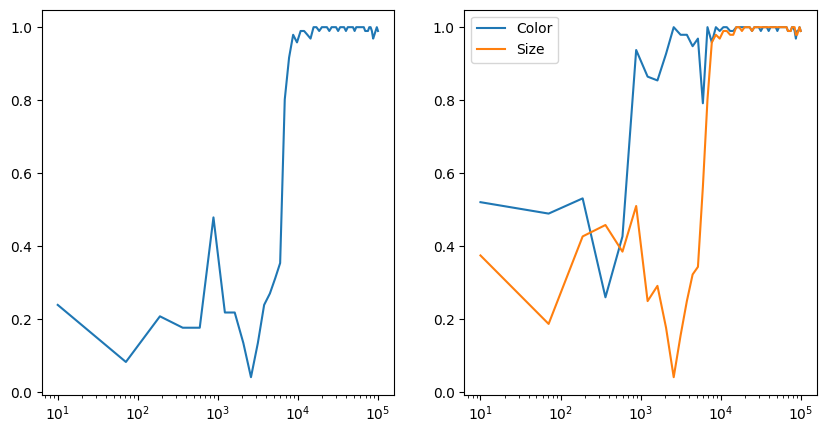

In [69]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(save_steps,rightss_te[:,:,l_te==l].prod(-1).mean(-1).mean(0))
plt.xscale("log")
plt.subplot(1,2,2)
rightss_te_l=rightss_te[:,:,l_te==l]
plt.plot(save_steps,rightss_te_l[:,:,:,0].mean((0,2)),label="Color")
plt.plot(save_steps,rightss_te_l[:,:,:,1].mean((0,2)),label="Size")
#plt.plot(rightss_te_l[0,:,:,2].mean(-1),label="BG Color")
plt.legend()
plt.xscale("log")

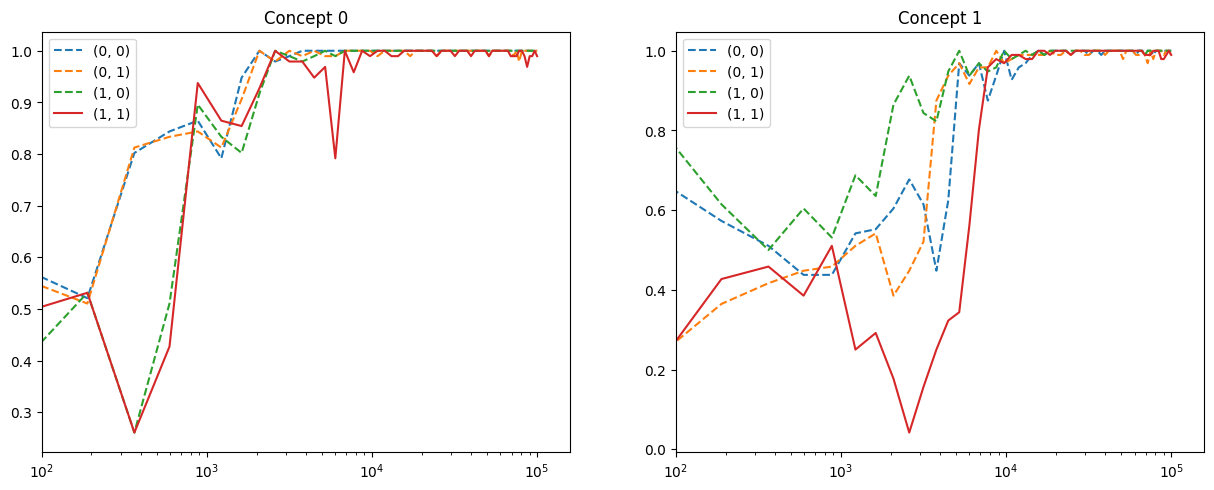

In [64]:
fig=plt.figure(figsize=(15,12))
for i_concept in range(len(classifier.n_classes)):
    plt.subplot(2,2,i_concept+1)
    for l in range(n_classes):
        if l in tri:
            plt.plot(save_steps,rightss_tr[:,:,l_tr==l][...,i_concept].mean(-1).mean(0),ls="--",label=f"{classifier.unravel_index(l)}")
        else:
            plt.plot(save_steps,rightss_te[:,:,l_te==l][...,i_concept].mean(-1).mean(0),label=f"{classifier.unravel_index(l)}")
    plt.xscale("log")
    plt.xlim(left=100)
    plt.legend()
    plt.title(f"Concept {i_concept}")

In [30]:
classifier.n_classes

[2, 2]

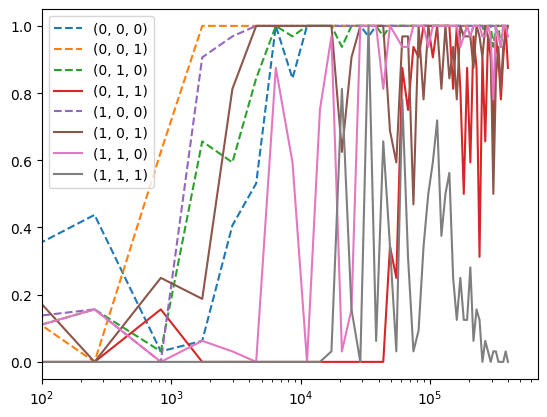

In [83]:
for l in range(8):
    if l in tri:
        plt.plot(save_steps,rightss_tr[:,:,l_tr==l].prod(-1).mean(-1)[1],ls="--",label=f"{classifier.unravel_index(l)}")
    else:
        plt.plot(save_steps,rightss_te[:,:,l_te==l].prod(-1).mean(-1)[1],label=f"{classifier.unravel_index(l)}")
plt.xscale("log")
plt.xlim(left=100)
plt.legend()

In [75]:
rightss_tr[:,:,l_tr==1,1].shape

(2, 50, 32)

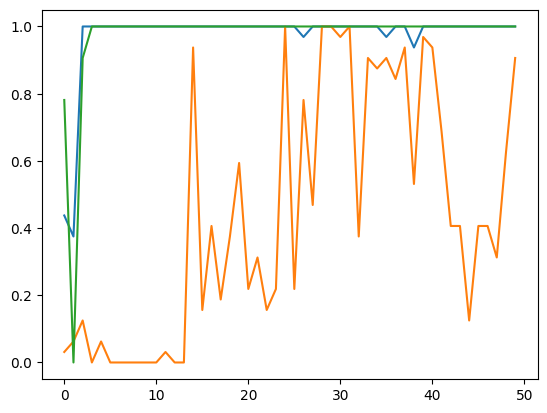

In [43]:
rightss_te_l=rightss_te[:,:,l_te==l]
plt.plot(rightss_te_l[0,:,:,0].mean(-1))
plt.plot(rightss_te_l[0,:,:,1].mean(-1))
plt.plot(rightss_te_l[0,:,:,2].mean(-1))

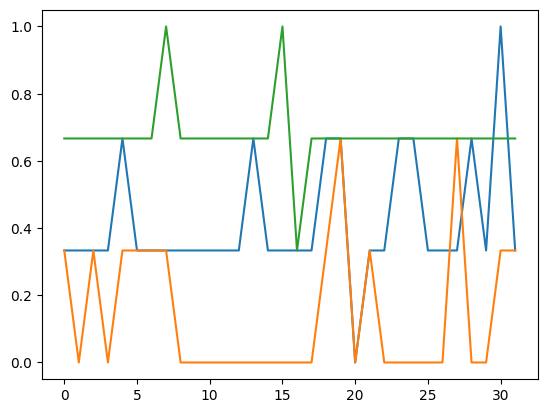

In [36]:
plt.plot(rightss_te[0,:,l_te==l][:,0].mean(-1))
plt.plot(rightss_te[0,:,l_te==l][:,1].mean(-1))
plt.plot(rightss_te[0,:,l_te==l][:,2].mean(-1))

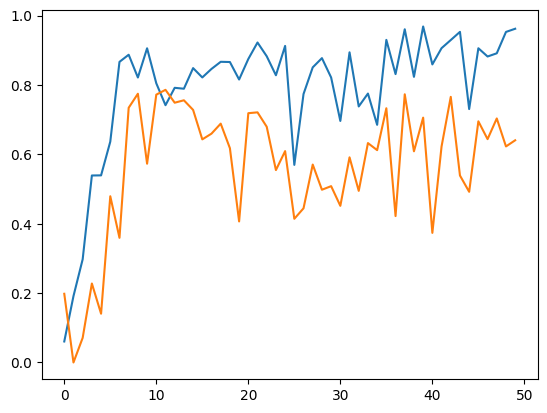

In [89]:
plt.plot(rightprobss_tr.prod(-1).mean(-1))
plt.plot(rightprobss_te.prod(-1).mean(-1))

In [74]:
right_classes=classifier.unravel_index(l_te)

In [75]:
i_step=33
right_probs=[]
indarr=np.arange(128)
for i_con,right_class in enumerate(right_classes):
    right_prob=classprobs_pred_te[i_step][i_con][indarr,right_class]
    right_probs.append(right_prob)
right_probs=np.stack(right_probs,axis=-1)
right_probs.shape

(128, 3)

In [76]:
right_probs.prod(-1)

array([1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 

In [68]:
classprobs_pred_tr[i_step][i_con].shape

(128, 2)

In [ ]:
right_probs.mean

In [57]:
len(classprobs_pred_tr[0])

3

In [38]:
gens_tr.shape

(30, 128, 3, 32, 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


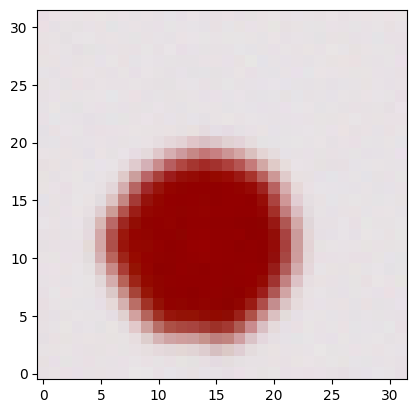

In [39]:
i=np.random.random()
plt.imshow(gens_te[-1,0].transpose(2,1,0),origin="lower")

In [13]:
y_tr.shape

(128, 11)

In [58]:
tri=np.nonzero(config["n_samples_train"])[0]
means=np.array(config["means"])
md_from_orig=means.sum(1)
in_hull=md_from_orig<=(1.+1e-5)
out_of_hull=md_from_orig>(1.+1e-5)
i_in_hull=np.nonzero(in_hull)[0]
i_out_of_hull=np.nonzero(out_of_hull)[0]
i_in_hull=np.array(list(set(list(i_in_hull))-set(list(tri))))
len(tri),len(i_out_of_hull),len(i_in_hull)

(7, 6, 3)

In [59]:
tri_accs=[]
inh_accs=[]
ooh_accs=[]
for i,plot_data in enumerate(plot_datas):
    save_steps=plot_data["save_steps"]

    tri_accs_=[]
    for i in tri:
        acc=plot_data["accs_perclass"][i]
        tri_accs_.append(acc)
    tri_accs.append(np.array(tri_accs_).mean(0))

    inh_accs_=[]
    for i in i_in_hull:
        acc=plot_data["accs_perclass"][i]
        inh_accs_.append(acc)
    inh_accs.append(np.array(inh_accs_).mean(0))

    ooh_accs_=[]
    for i in i_out_of_hull:
        acc=plot_data["accs_perclass"][i]
        ooh_accs_.append(acc)
    ooh_accs.append(np.array(ooh_accs_).mean(0))

triaccm=np.array(tri_accs).mean(0)
inhaccm=np.array(inh_accs).mean(0)
oohaccm=np.array(ooh_accs).mean(0)

In [60]:
ckpts=plot_datas[0]["ckpts"]
ckpt_keys=ckpts[0].keys()
tckpt={}
for key in ckpt_keys:
    if "model.score_model" not in key:
        continue
    key_=key.replace("model.score_model.","")
    tckpt[key_]=[]
    for ckpt in ckpts:
        tckpt[key_].append(ckpt[key])  
    tckpt[key_]=torch.stack(tckpt[key_],axis=0).cpu().numpy()
    print(key_,tckpt[key_].shape)

embed_t_conditioning.0.weight (60, 256, 64)
embed_t_conditioning.0.bias (60, 256)
embed_t_conditioning.2.weight (60, 256, 256)
embed_t_conditioning.2.bias (60, 256)
embedders.0.0.0.weight (60, 1024, 256)
embedders.0.0.0.bias (60, 1024)
embedders.0.0.2.weight (60, 1024, 1024)
embedders.0.0.2.bias (60, 1024)
embedders.0.1.0.weight (60, 1024, 2)
embedders.0.1.0.bias (60, 1024)
embedders.0.1.2.weight (60, 1024, 1024)
embedders.0.1.2.bias (60, 1024)
layers.0.weight (60, 1024, 2)
layers.0.bias (60, 1024)
layers.1.weight (60, 2, 1024)
layers.1.bias (60, 2)


In [61]:
tckpt['embedders.0.1.2.weight'].shape

(60, 1024, 1024)

In [62]:
eigvs=np.linalg.eigvals(tckpt['embedders.0.1.2.weight'])
eigvs.shape

(60, 1024)

In [63]:
eigvs_abs=np.abs(eigvs)**2

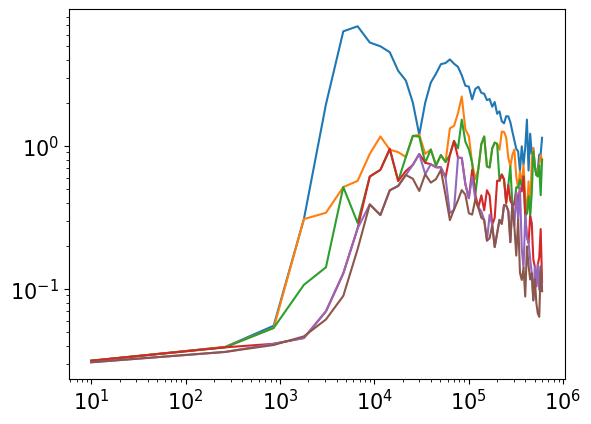

In [64]:
plt.plot(save_steps,eigvs_abs[:,0])
plt.plot(save_steps,eigvs_abs[:,1])
plt.plot(save_steps,eigvs_abs[:,2])
plt.plot(save_steps,eigvs_abs[:,3])
plt.plot(save_steps,eigvs_abs[:,4])
plt.plot(save_steps,eigvs_abs[:,5])
plt.xscale("log")
plt.yscale("log")

In [65]:
def mMn(vals):
    m=vals.min()
    M=vals.max()
    return (vals-m)/(M-m)

Text(0, 0.5, 'Eigenvalue')

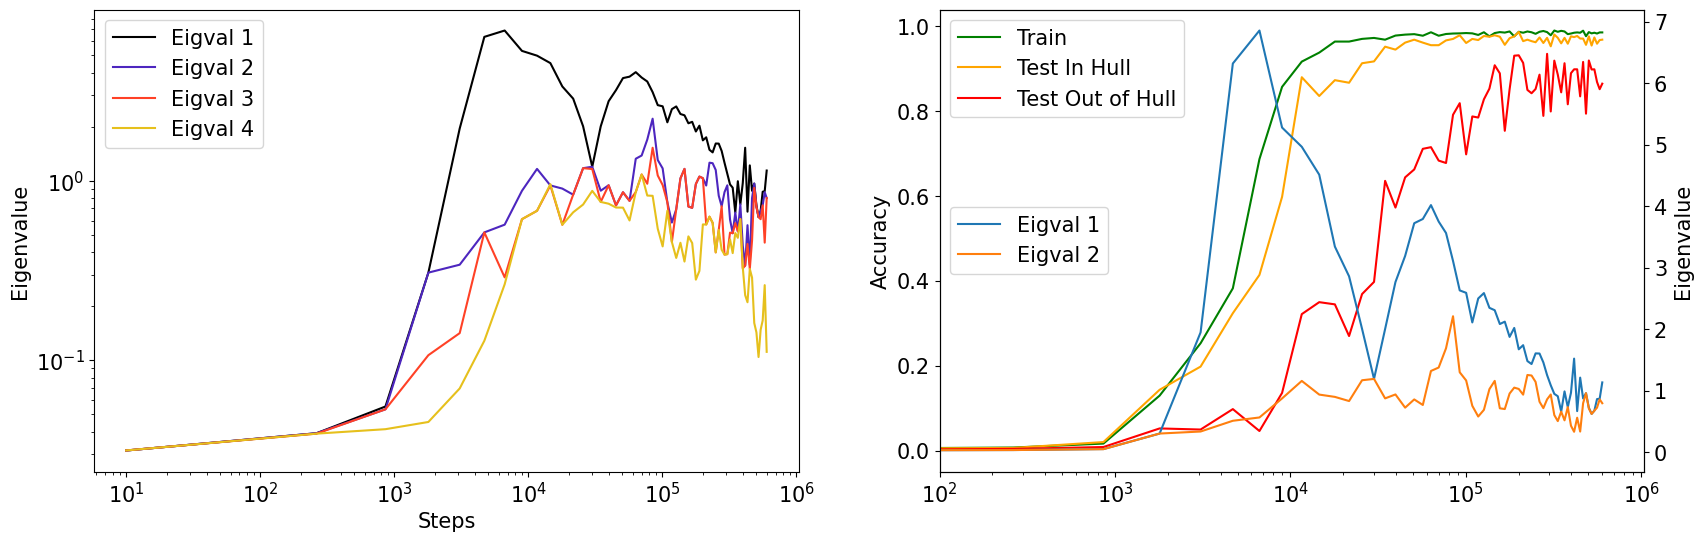

In [66]:
x_left=100
plt.figure(figsize=(20,6))
plt.rcParams.update({'font.size': 15})
plt.subplot(1,2,1)
cmap=plt.get_cmap("CMRmap")
for i in range(4):
    plt.plot(save_steps,eigvs_abs[:,i],color=cmap(i/4),label="Eigval "+str(i+1))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Eigenvalue")
plt.legend()

plt.subplot(1,2,2)
plt.plot(save_steps,triaccm,c="green",label="Train")
plt.plot(save_steps,inhaccm,c="orange",label="Test In Hull")
plt.plot(save_steps,oohaccm,c="red",label="Test Out of Hull")
plt.xscale("log")
plt.legend()
plt.xlim(left=x_left)
plt.ylabel("Accuracy")
plt.twinx()
plt.plot(save_steps,eigvs_abs[:,0],label="Eigval 1")
plt.plot(save_steps,eigvs_abs[:,1],label="Eigval 2")
plt.legend(loc="center left")
plt.xlabel("Steps")
plt.ylabel("Eigenvalue")
#plt.savefig("./figures/eigen_predict.png")

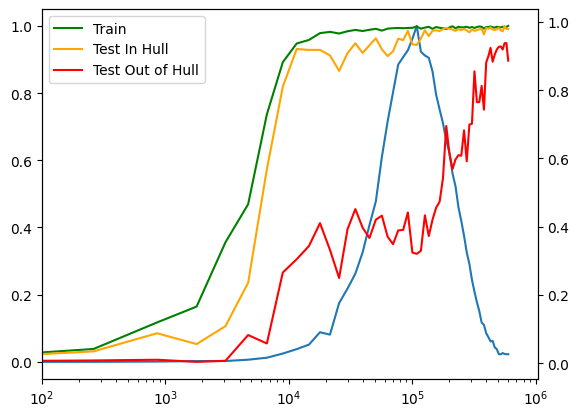

In [20]:
x_left=100
min_vlb=plot_data["min_vlb"]
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.0.weight'][:,:,0],axis=1))
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.0.bias'][:,:],axis=1))
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.2.bias'][:,:],axis=1))
plt.plot(save_steps,mMn(eigvs_abs[:,0]),label="Max. Eigval. of Cond. Proj.")
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.0.weight'][:,:,0],axis=1)))
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.0.bias'],axis=1)))
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.1.bias'],axis=1)))
plt.xscale("log")
plt.xlim(left=x_left)
#plt.twinx()
#plt.plot(save_steps,val_losses-min_vlb,c="green",alpha=0.5)
#plt.plot(save_steps,te_losses-min_vlb,c="red",alpha=0.5)
#plt.yscale("log")
plt.twinx()
plt.plot(save_steps,triaccm,c="green",label="Train")
plt.plot(save_steps,inhaccm,c="orange",label="Test In Hull")
plt.plot(save_steps,oohaccm,c="red",label="Test Out of Hull")
#plt.plot(save_steps,acctr_m,c="green",ls="--")
#plt.plot(save_steps,accte_m,c="red",ls="--")
plt.legend()
